# Full pipeline for upscaling and colorization

# Python setup

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.init as init
import os.path

from unet import UNet

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [2]:
# use the Metal backend if available (for Apple computers)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
# use CUDA if available (for NVIDIA cards)
elif torch.cuda.is_available():
    device = torch.device('cuda')
# otherwise, use the CPU
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [3]:
INPUT_SIZE = 80
FACTOR = 2
OUTPUT_SIZE = INPUT_SIZE * FACTOR

BATCH_SIZE = 32

In [129]:
def extract_lab_channels(image):
    lab_image = rgb2lab(image)
    l_channel = lab_image[:, :, 0] / 50 - 1
    ab_channels = lab_image[:, :, 1:] / 100
    return l_channel, ab_channels

def colorize_using_ab_channels(original_l_channel, ab_channels):
    l_channel = (original_l_channel + 1) * 50
    ab_channels = ab_channels * 100
    lab_image = np.concatenate([l_channel, ab_channels], axis=-1)
    rgb_image = lab2rgb(lab_image)
    return rgb_image

# Dataset setup

In [133]:

download = not os.path.exists('./data/imagenette2-160')
data = torchvision.datasets.Imagenette("data", split='train', size="160px", download=download)


class ImagesDataset(Dataset):
    def __init__(self, data, parallel = True):
        self.data = data
        self.parallel = parallel

    def __getitem__(self, idx):
        tr_global = transforms.Compose([
            transforms.Resize((OUTPUT_SIZE, OUTPUT_SIZE), Image.BICUBIC),
            transforms.ToTensor()
        ])
        
        tr_lr = transforms.Resize((INPUT_SIZE, INPUT_SIZE), Image.BICUBIC)
        
        tr_hr = transforms.Resize((OUTPUT_SIZE, OUTPUT_SIZE), Image.BICUBIC)

        img = self.data[idx][0]

        image_lab = rgb2lab(tr_global(img).permute(1, 2, 0).numpy())

        L_org = torch.tensor(image_lab[:, :, 0] / 50 - 1).unsqueeze(0)
        ab_org = torch.tensor(image_lab[:, :, 1:] / 100).permute(2,0,1)

        lr = tr_lr(L_org)
        hr = tr_hr(L_org)

        if self.parallel:
            L = tr_lr(L_org)
            ab = tr_lr(ab_org)
        else:
            L = L_org
            ab = ab_org
       
        return {'L': L, 'ab' : ab, 'lr': lr, 'hr': hr, 'l_org': L_org, 'ab_org' : ab_org}


    def __len__(self):
        return len(self.data)

full_dataset = ImagesDataset(data, parallel=True)
n_train = int(len(full_dataset) * 0.8)
n_test = len(full_dataset) - n_train
dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [n_train, n_test])

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [131]:
next(iter(dataloader_test))

{'L': tensor([[[[ 0.6115,  0.6182,  0.6274,  ...,  0.6247,  0.6103,  0.5961],
           [ 0.6202,  0.6272,  0.6335,  ...,  0.6216,  0.6097,  0.5981],
           [ 0.6280,  0.6363,  0.6388,  ...,  0.6135,  0.6068,  0.6049],
           ...,
           [-0.1200, -0.1060, -0.0938,  ..., -0.2389, -0.2732, -0.2546],
           [-0.1295, -0.1267, -0.1170,  ..., -0.2362, -0.2494, -0.2559],
           [-0.1513, -0.1523, -0.1543,  ..., -0.2138, -0.2310, -0.2401]]]]),
 'ab': tensor([[[[-0.0441, -0.0441, -0.0441,  ..., -0.0365, -0.0366, -0.0366],
           [-0.0435, -0.0435, -0.0434,  ..., -0.0366, -0.0366, -0.0366],
           [-0.0362, -0.0362, -0.0362,  ..., -0.0366, -0.0366, -0.0366],
           ...,
           [ 0.0269,  0.0269,  0.0268,  ..., -0.0145, -0.0146, -0.0145],
           [ 0.0282,  0.0281,  0.0281,  ..., -0.0144, -0.0144, -0.0144],
           [ 0.0317,  0.0317,  0.0317,  ..., -0.0143, -0.0144, -0.0144]],
 
          [[-0.1053, -0.1052, -0.1051,  ..., -0.0801, -0.0803, -0.0804],
 

# Model

Colorization

In [5]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
            for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        self.i = 0
        self.lambda_L1 = lambda_L1
        
        if net_G is None: # first training
            self.net_G = init_model(UNet(n_channels=1, n_classes=2))
        else: # resume training
            self.net_G = net_G.to(device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64))
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = torch.optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, l, ab):
        self.i += 1
        self.L = l.to(device)
        self.ab = ab.to(device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

def init_model(model):
    model = model.to(device)
    model = init_weights(model)
    return model

Upscaling

In [6]:
class LRNet(nn.Module):
    def __init__(self, upscale_factor):
        super(LRNet, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 1 * upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

## Training

In [7]:
def train_epoch(epoch, model, dataloader, optimizer, criterion, type):
    epoch_loss = 0
    for batch in tqdm(dataloader):
        l, ab, lr, hr = batch["L"], batch["ab"], batch["lr"], batch["hr"]

        if type == "COLOR":
            inp = l 
            target = ab
        else:
            inp = lr.to(device)
            target = hr.to(device)
        optimizer.zero_grad()
        if type == "COLOR":
            model.setup_input(inp, target)
            model.optimize()
            epoch_loss += model.loss_G.item()
            
        else:
            loss = criterion(model(inp), target)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

    print("[TRAIN epoch {}] Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

def train_model(model, dataloader, epochs, type):
    model.to(device)
    model.train()

    criterion = nn.MSELoss()
    if type == "COLOR":
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    for epoch in range(epochs):
        train_epoch(epoch, model, dataloader, optimizer, criterion, type)
        # scheduler.step()

In [147]:
#lr_model = LRNet(FACTOR)
lr_model = torch.load("upscaling.pt")
print(lr_model)
train_model(lr_model, dataloader_train, 10, "SCAL")
torch.save(lr_model, "upscaling.pt")

LRNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
)


/tmp/ipykernel_135462/1239091838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lr_model = torch.load("upscaling.pt")


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 0] Loss: 0.0156


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 1] Loss: 0.0068


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 2] Loss: 0.0066


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 3] Loss: 0.0066


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 4] Loss: 0.0071


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 5] Loss: 0.0064


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 6] Loss: 0.0063


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 7] Loss: 0.0068


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 8] Loss: 0.0064


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 9] Loss: 0.0062


In [136]:
color_model = MainModel()
print(color_model)
train_model(color_model, dataloader_train, 2, "COLOR")
torch.save(color_model, "colorization.pt")

MainModel(
  (net_G): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kern

  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 0] Loss: 11.5957


  0%|          | 0/237 [00:00<?, ?it/s]

[TRAIN epoch 1] Loss: 11.9129


In [20]:
color_model = torch.load("../colorization/colorization.pt")

/tmp/ipykernel_49751/3558561174.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  color_model = torch.load("../colorization/colorization.pt")


In [9]:
upscaling_model = torch.load("upscaling.pt")

/tmp/ipykernel_135462/1687852073.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  upscaling_model = torch.load("upscaling.pt")


In [10]:
bicarre_model = torchvision.transforms.Resize(OUTPUT_SIZE)

In [49]:
def full_pipeline(color,upscale,data,linear=False):
    color.to(device)
    upscale.to(device)
    color.net_G.eval()
    data = torch.Tensor(data).to(device)
    L = upscale(data).detach()
    if linear:
        ab_up = color(L)
    else:
        color.setup_input(data,torch.Tensor(np.zeros(data.shape)))
        color.forward()
        ab = color.fake_color.detach()
        ab_up = bicarre_model(ab)
    color.net_G.train()
    return L.detach(),ab_up.detach()

torch.Size([1, 160, 160])
torch.Size([2, 160, 160])
torch.Size([1, 80, 80])
torch.Size([1, 80, 80])
torch.Size([1, 160, 160])
torch.Size([2, 80, 80])
torch.Size([1, 160, 160])
torch.Size([2, 160, 160])
(160, 160, 3)


/tmp/ipykernel_135462/2824090002.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


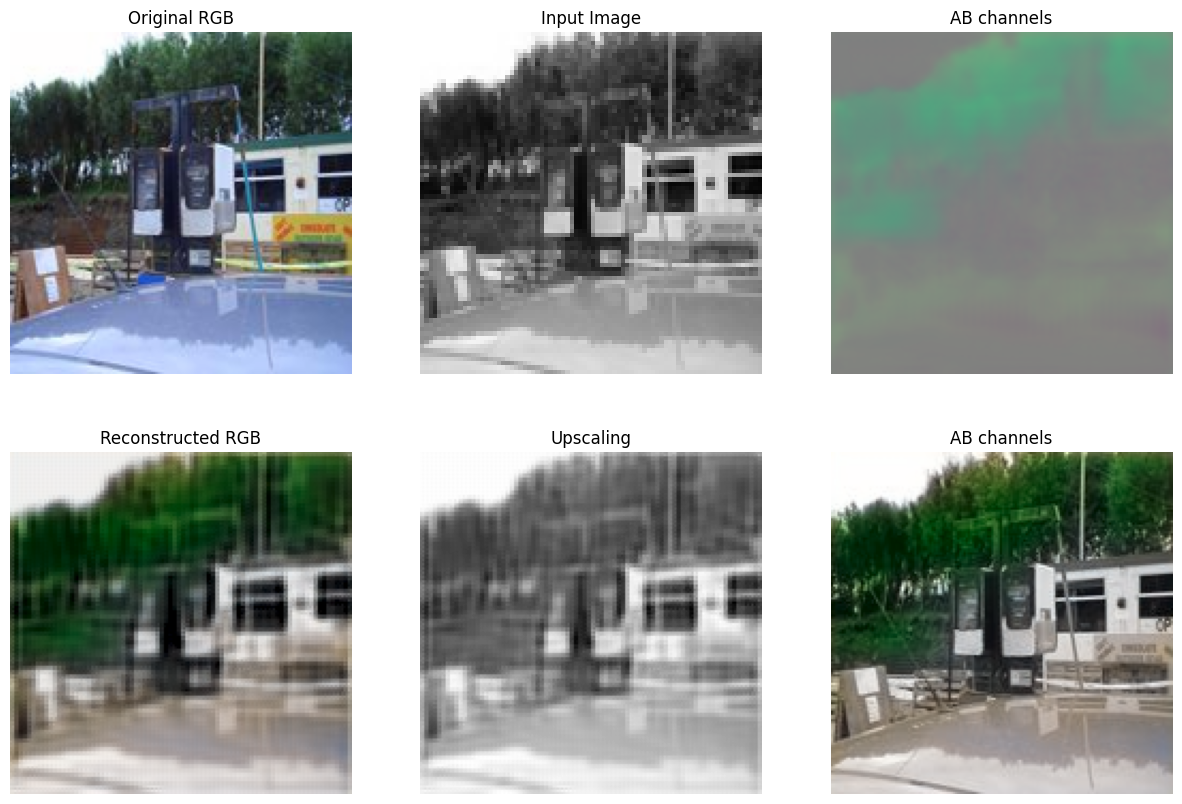

In [152]:
image = next(iter(dataloader_test))

idx = np.random.randint(BATCH_SIZE)

print(image["l_org"][idx].shape)
print(image["ab_org"][idx].shape)
print(image["L"][idx].shape)
print(image["lr"][idx].shape)
print(image["hr"][idx].shape)
print(image["ab"][idx].shape)

l_res, ab_res = full_pipeline(color_model, upscaling_model, image["lr"], linear=False)

print(l_res[idx].shape)
print(ab_res[idx].shape)
print(lab_to_rgb(image['l_org'][idx],image['ab_org'][idx]).shape)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Original RGB")
plt.imshow(colorize_using_ab_channels(image['l_org'][idx].cpu().permute(1, 2, 0), image['ab_org'][idx].cpu().permute(1, 2, 0)))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Reconstructed RGB")
plt.imshow(colorize_using_ab_channels(l_res[idx].cpu().permute(1, 2, 0), ab_res[idx].cpu().permute(1, 2, 0)))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Input Image")
plt.imshow(image["lr"][idx].cpu().permute(1, 2, 0), cmap='gray')

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Upscaling")
plt.imshow(l_res[idx].cpu().permute(1, 2, 0), cmap='gray')

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("AB channels")
plt.imshow((((np.concatenate((ab_res[idx].cpu().permute(1,2,0), np.zeros((OUTPUT_SIZE, OUTPUT_SIZE,1))), axis=-1) + 1) / 2)))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("AB channels")
plt.imshow(colorize_using_ab_channels(image['l_org'][idx].cpu().permute(1, 2, 0),ab_res[idx].cpu().permute(1, 2, 0)))
 